# Outline
* Import Useful Functions and Data
* Compute correlation between company's variables and stock price
* Select variables which are strongly (r > 0.7) and normally (0.4 < r < 0.7) correlated to stock price (0.4 < r < 0.7)
* Prepare data
* Conduct clustering analysis based on all numerical variables
* Discover the best cluster of stocks to buy
* Appendix: Collect tickers from all clusters

#### Import Useful Functions and Data

In [ ]:
# imports - usual suspects
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for distance and h-clustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform


# sklearn does have some functionality too, but mostly a wrapper to scipy
from sklearn.metrics import pairwise_distances 
from sklearn.preprocessing import StandardScaler


In [ ]:
stock_data= pd.read_csv("stock-fundamentals.csv")

In [ ]:
stock_data.head(3)

,Quarter end,Shares,Shares split adjusted,Split factor,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Non-controlling interest,Preferred equity,Goodwill & intangibles,Long-term debt,Revenue,Earnings,Earnings available for common stockholders,EPS basic,EPS diluted,Dividend per share,Cash from operating activities,Cash from investing activities,Cash from financing activities,Cash change during period,Cash at end of period,Capital expenditures,Price,Price high,Price low,ROE,ROA,Book value of equity per share,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Equity to assets ratio,Net margin,Asset turnover,Free cash flow per share,Current ratio,ticker,quarter_end
0,NaN,3588919000,3588919000,1,118318000000,5.693800e+10,87263000000,2.031500e+10,30572000000,483000000,0,49881000000,51561000000,9.562000e+09,2333000000,2333000000,0.63,0.61,0.19,5.460000e+08,1.920000e+09,-1.002300e+10,-7631000000,10824000000,421000000,49.23,52.11,46.34,0.0982,0.0305,8.52,4.90,54.10,4.37,0.7371,1.6865,0.2584,0.1001,0.30,0.03,2.8028,ORCL,2018-11-30
1,NaN,261043625,261043625,1,53289000000,1.343800e+10,33995000000,9.496000e+09,19294000000,0,0,6908000000,16399000000,1.782400e+10,935000000,933000000,3.56,3.51,0.65,1.478000e+09,-1.480000e+09,-2.300000e+08,-246000000,2123000000,1455000000,233.57,259.25,207.90,0.2586,0.0950,73.91,3.21,13.20,12.17,0.1301,0.8500,0.3621,0.0722,1.31,0.09,1.4151,FDX,2018-11-30
2,NaN,359091176,359091176,1,7002400000,5.290000e+09,4577900000,4.306800e+09,2424500000,0,0,938600000,0,8.589000e+08,235800000,235800000,0.66,0.65,0.56,2.235000e+08,1.203000e+08,-2.733000e+08,70500000,510600000,36600000,69.45,76.02,62.89,0.4361,0.1366,6.75,10.44,26.51,21.27,0.8085,0.0000,0.3462,0.2799,0.49,0.52,1.2283,PAYX,2018-11-30


In [ ]:
stock_data.columns

Index(['Quarter end', 'Shares', 'Shares split adjusted', 'Split factor',
       'Assets', 'Current Assets', 'Liabilities', 'Current Liabilities',
       'Shareholders equity', 'Non-controlling interest', 'Preferred equity',
       'Goodwill & intangibles', 'Long-term debt', 'Revenue', 'Earnings',
       'Earnings available for common stockholders', 'EPS basic',
       'EPS diluted', 'Dividend per share', 'Cash from operating activities',
       'Cash from investing activities', 'Cash from financing activities',
       'Cash change during period', 'Cash at end of period',
       'Capital expenditures', 'Price', 'Price high', 'Price low', 'ROE',
       'ROA', 'Book value of equity per share', 'P/B ratio', 'P/E ratio',
       'Cumulative dividends per share', 'Dividend payout ratio',
       'Long-term debt to equity ratio', 'Equity to assets ratio',
       'Net margin', 'Asset turnover', 'Free cash flow per share',
       'Current ratio', 'ticker', 'quarter_end'],
      dtype='object')

#### Compute correlation between company's variables and stock price

In [ ]:
stock_corr=stock_data.corr()
stock_corr.head(3)

,Quarter end,Shares,Shares split adjusted,Split factor,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Non-controlling interest,Preferred equity,Goodwill & intangibles,Long-term debt,Revenue,Earnings,Earnings available for common stockholders,EPS basic,EPS diluted,Dividend per share,Cash from operating activities,Cash from investing activities,Cash from financing activities,Cash change during period,Cash at end of period,Capital expenditures,Price,Price high,Price low,ROE,ROA,Book value of equity per share,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Equity to assets ratio,Net margin,Asset turnover,Free cash flow per share,Current ratio
Quarter end,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Shares,NaN,1.0,1.0,NaN,0.431564,0.678454,0.385363,0.638459,0.599606,0.372297,0.213228,0.608374,0.137334,0.497637,0.207417,0.18862,-0.020558,-0.020551,0.047773,0.600637,-0.257322,-0.18511,0.110374,0.397205,0.485254,-0.021309,-0.021321,-0.021295,-0.032045,-0.023187,-0.020382,-0.020415,0.063328,0.023372,0.036053,-0.00279,-0.124559,0.111818,-0.129194,-0.020097,-0.074618
Shares split adjusted,NaN,1.0,1.0,NaN,0.431564,0.678454,0.385363,0.638459,0.599606,0.372297,0.213228,0.608374,0.137334,0.497637,0.207417,0.18862,-0.020558,-0.020551,0.047773,0.600637,-0.257322,-0.18511,0.110374,0.397205,0.485254,-0.021309,-0.021321,-0.021295,-0.032045,-0.023187,-0.020382,-0.020415,0.063328,0.023372,0.036053,-0.00279,-0.124559,0.111818,-0.129194,-0.020097,-0.074618


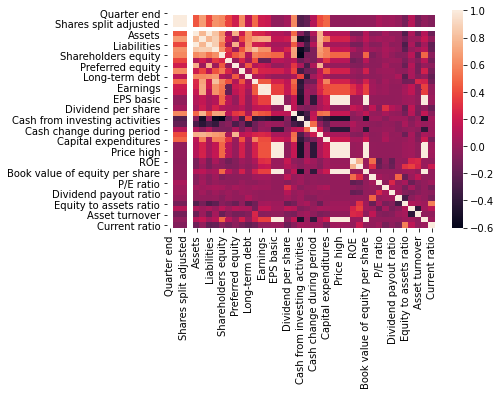

In [ ]:
sns.heatmap(stock_corr);

#### Select variables which are strongly (r > 0.7) and normally (0.4 < r < 0.7) correlated to stock price (0.4 < r < 0.7)

In [ ]:
stock_normal_strong_corr= stock_corr.loc[stock_corr['Price'] > 0.4, stock_corr['Price'] > 0.4]

In [ ]:
stock_normal_strong_corr

,Shareholders equity,Earnings,Earnings available for common stockholders,EPS basic,EPS diluted,Price,Price high,Price low,Book value of equity per share,Free cash flow per share
Shareholders equity,1.000000,0.535811,0.521238,0.480762,0.480759,0.483314,0.483284,0.483349,0.481272,0.482153
Earnings,0.535811,1.000000,0.990598,0.362869,0.362856,0.418282,0.418269,0.418297,0.361292,0.362501
Earnings available for common stockholders,0.521238,0.990598,1.000000,0.359796,0.359782,0.422041,0.422028,0.422056,0.358142,0.359202
EPS basic,0.480762,0.362869,0.359796,1.000000,1.000000,0.999962,0.999962,0.999962,0.999988,0.999820
EPS diluted,0.480759,0.362856,0.359782,1.000000,1.000000,0.999962,0.999961,0.999962,0.999988,0.999820
Price,0.483314,0.418282,0.422041,0.999962,0.999962,1.000000,1.000000,1.000000,0.999945,0.999894
Price high,0.483284,0.418269,0.422028,0.999962,0.999961,1.000000,1.000000,1.000000,0.999944,0.999893
Price low,0.483349,0.418297,0.422056,0.999962,0.999962,1.000000,1.000000,1.000000,0.999945,0.999894
Book value of equity per share,0.481272,0.361292,0.358142,0.999988,0.999988,0.999945,0.999944,0.999945,1.000000,0.999799
Free cash flow per share,0.482153,0.362501,0.359202,0.999820,0.999820,0.999894,0.999893,0.999894,0.999799,1.000000


In [ ]:
strong_normal=stock_normal_strong_corr.drop(['Price', 'Price high', 'Price low'], axis=0)

In [ ]:
strong_normal_final=strong_normal.loc[:,['Price']].sort_values(by=['Price'], ascending=False)
strong_normal_final

,Price
EPS basic,0.999962
EPS diluted,0.999962
Book value of equity per share,0.999945
Free cash flow per share,0.999894
Shareholders equity,0.483314
Earnings available for common stockholders,0.422041
Earnings,0.418282


In [ ]:
strong_final=strong_normal_final.loc[['EPS basic', 'EPS diluted', 'Book value of equity per share', 'Free cash flow per share']]
normal_final=strong_normal_final.loc[['Shareholders equity', 'Earnings available for common stockholders', 'Earnings']]

In [ ]:
strong_final

,Price
EPS basic,0.999962
EPS diluted,0.999962
Book value of equity per share,0.999945
Free cash flow per share,0.999894


In [ ]:
normal_final


,Price
Shareholders equity,0.483314
Earnings available for common stockholders,0.422041
Earnings,0.418282


#### Prepare data

In [ ]:
stock_interpret=stock_data.copy()
stock_interpret.fillna(0, inplace=True)

In [ ]:
stock_interpret.isna().sum().sum()

0

In [ ]:
stock_interpret.head()

,Quarter end,Shares,Shares split adjusted,Split factor,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Non-controlling interest,Preferred equity,Goodwill & intangibles,Long-term debt,Revenue,Earnings,Earnings available for common stockholders,EPS basic,EPS diluted,Dividend per share,Cash from operating activities,Cash from investing activities,Cash from financing activities,Cash change during period,Cash at end of period,Capital expenditures,Price,Price high,Price low,ROE,ROA,Book value of equity per share,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Equity to assets ratio,Net margin,Asset turnover,Free cash flow per share,Current ratio,ticker,quarter_end
0,0.0,3588919000,3588919000,1,118318000000,5.693800e+10,87263000000,2.031500e+10,30572000000,483000000,0,49881000000,51561000000,9.562000e+09,2333000000,2333000000,0.63,0.61,0.19,5.460000e+08,1.920000e+09,-1.002300e+10,-7631000000,10824000000,421000000,49.23,52.11,46.34,0.0982,0.0305,8.52,4.90,54.10,4.37,0.7371,1.6865,0.2584,0.1001,0.30,0.03,2.8028,ORCL,2018-11-30
1,0.0,261043625,261043625,1,53289000000,1.343800e+10,33995000000,9.496000e+09,19294000000,0,0,6908000000,16399000000,1.782400e+10,935000000,933000000,3.56,3.51,0.65,1.478000e+09,-1.480000e+09,-2.300000e+08,-246000000,2123000000,1455000000,233.57,259.25,207.90,0.2586,0.0950,73.91,3.21,13.20,12.17,0.1301,0.8500,0.3621,0.0722,1.31,0.09,1.4151,FDX,2018-11-30
2,0.0,359091176,359091176,1,7002400000,5.290000e+09,4577900000,4.306800e+09,2424500000,0,0,938600000,0,8.589000e+08,235800000,235800000,0.66,0.65,0.56,2.235000e+08,1.203000e+08,-2.733000e+08,70500000,510600000,36600000,69.45,76.02,62.89,0.4361,0.1366,6.75,10.44,26.51,21.27,0.8085,0.0000,0.3462,0.2799,0.49,0.52,1.2283,PAYX,2018-11-30
3,0.0,665541059,665541059,1,26706412000,1.354041e+10,13650844000,1.017634e+10,12678856000,376712000,0,6219615000,19896000,1.060555e+10,1274720000,1274720000,2.00,1.96,1.46,1.027508e+09,-2.728680e+08,-1.462168e+09,-697570000,4363790000,72892000,163.13,175.64,150.63,0.3961,0.1727,19.05,10.44,25.73,17.64,0.4436,0.0016,0.4747,0.0999,1.73,1.43,1.3306,ACN,2018-11-30
4,0.0,943444736,943444736,1,69941000000,2.008300e+10,43678000000,2.509900e+10,25609000000,654000000,0,28393000000,11646000000,3.379300e+10,1123000000,1123000000,1.18,1.18,0.44,4.590000e+08,-6.350000e+08,3.900000e+08,208000000,1183000000,470000000,76.37,85.31,67.42,0.1996,0.0763,27.14,2.79,15.09,5.74,0.3054,0.4548,0.3662,0.0396,1.93,-0.01,0.8002,WBA,2018-11-30


In [ ]:
stock_select=stock_interpret.copy()

COLS= ['Quarter end', 'Split factor', 'ticker', 'quarter_end']

stock_drop=stock_select.loc[:, COLS]
stock_cluster=stock_select.drop(columns=COLS)

In [ ]:
stock_cluster.head()

,Shares,Shares split adjusted,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Non-controlling interest,Preferred equity,Goodwill & intangibles,Long-term debt,Revenue,Earnings,Earnings available for common stockholders,EPS basic,EPS diluted,Dividend per share,Cash from operating activities,Cash from investing activities,Cash from financing activities,Cash change during period,Cash at end of period,Capital expenditures,Price,Price high,Price low,ROE,ROA,Book value of equity per share,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Equity to assets ratio,Net margin,Asset turnover,Free cash flow per share,Current ratio
0,3588919000,3588919000,118318000000,5.693800e+10,87263000000,2.031500e+10,30572000000,483000000,0,49881000000,51561000000,9.562000e+09,2333000000,2333000000,0.63,0.61,0.19,5.460000e+08,1.920000e+09,-1.002300e+10,-7631000000,10824000000,421000000,49.23,52.11,46.34,0.0982,0.0305,8.52,4.90,54.10,4.37,0.7371,1.6865,0.2584,0.1001,0.30,0.03,2.8028
1,261043625,261043625,53289000000,1.343800e+10,33995000000,9.496000e+09,19294000000,0,0,6908000000,16399000000,1.782400e+10,935000000,933000000,3.56,3.51,0.65,1.478000e+09,-1.480000e+09,-2.300000e+08,-246000000,2123000000,1455000000,233.57,259.25,207.90,0.2586,0.0950,73.91,3.21,13.20,12.17,0.1301,0.8500,0.3621,0.0722,1.31,0.09,1.4151
2,359091176,359091176,7002400000,5.290000e+09,4577900000,4.306800e+09,2424500000,0,0,938600000,0,8.589000e+08,235800000,235800000,0.66,0.65,0.56,2.235000e+08,1.203000e+08,-2.733000e+08,70500000,510600000,36600000,69.45,76.02,62.89,0.4361,0.1366,6.75,10.44,26.51,21.27,0.8085,0.0000,0.3462,0.2799,0.49,0.52,1.2283
3,665541059,665541059,26706412000,1.354041e+10,13650844000,1.017634e+10,12678856000,376712000,0,6219615000,19896000,1.060555e+10,1274720000,1274720000,2.00,1.96,1.46,1.027508e+09,-2.728680e+08,-1.462168e+09,-697570000,4363790000,72892000,163.13,175.64,150.63,0.3961,0.1727,19.05,10.44,25.73,17.64,0.4436,0.0016,0.4747,0.0999,1.73,1.43,1.3306
4,943444736,943444736,69941000000,2.008300e+10,43678000000,2.509900e+10,25609000000,654000000,0,28393000000,11646000000,3.379300e+10,1123000000,1123000000,1.18,1.18,0.44,4.590000e+08,-6.350000e+08,3.900000e+08,208000000,1183000000,470000000,76.37,85.31,67.42,0.1996,0.0763,27.14,2.79,15.09,5.74,0.3054,0.4548,0.3662,0.0396,1.93,-0.01,0.8002


In [ ]:
#scale the data
sc= StandardScaler()
ps= sc.fit_transform(stock_cluster)
ps=pd.DataFrame(ps, columns=stock_cluster.columns)

In [ ]:
ps.head(3)

,Shares,Shares split adjusted,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Non-controlling interest,Preferred equity,Goodwill & intangibles,Long-term debt,Revenue,Earnings,Earnings available for common stockholders,EPS basic,EPS diluted,Dividend per share,Cash from operating activities,Cash from investing activities,Cash from financing activities,Cash change during period,Cash at end of period,Capital expenditures,Price,Price high,Price low,ROE,ROA,Book value of equity per share,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Equity to assets ratio,Net margin,Asset turnover,Free cash flow per share,Current ratio
0,3.501389,3.501389,0.244390,3.646492,0.173296,1.470175,0.695771,0.184672,-0.134939,2.505787,0.310530,0.544829,1.039929,1.041677,-0.037434,-0.037447,-0.322522,-0.134143,0.928720,-3.513459,-3.580373,0.349033,0.232854,-0.039863,-0.039988,-0.039716,-0.211538,-0.359846,-0.038409,-0.013069,0.304792,-0.379328,0.152631,0.143821,-0.453208,-0.154753,-0.679356,-0.043949,0.881198
1,-0.260087,-0.260087,-0.033223,0.514092,-0.070607,0.450397,0.287431,-0.304031,-0.134939,-0.002048,0.025479,1.442800,0.274953,0.283265,-0.030292,-0.030377,0.934615,0.263152,-0.425868,0.073335,-0.120132,-0.081121,1.846332,-0.023407,-0.022960,-0.023938,0.617315,0.460873,-0.030550,-0.152476,-0.259105,-0.169569,-0.257785,-0.088844,0.051137,-0.387163,0.813477,-0.043548,-0.088317
2,-0.149264,-0.149264,-0.230824,-0.072639,-0.205302,-0.038727,-0.323358,-0.304031,-0.134939,-0.350412,-0.107464,-0.401084,-0.107644,-0.094424,-0.037361,-0.037349,0.688653,-0.271619,0.211705,0.057476,0.028164,-0.160833,-0.366973,-0.038058,-0.038022,-0.038100,1.534530,0.990205,-0.038622,0.443921,-0.075597,0.075151,0.200908,-0.325264,-0.026193,1.342999,-0.398526,-0.040673,-0.218825


#### Compute clustering analysis based on all numerical variables

In [ ]:
diste= pdist(ps.values)
distc= pdist(ps.values, metric="cosine")

In [ ]:
hclust_e=linkage(diste)
hclust_c=linkage(distc)

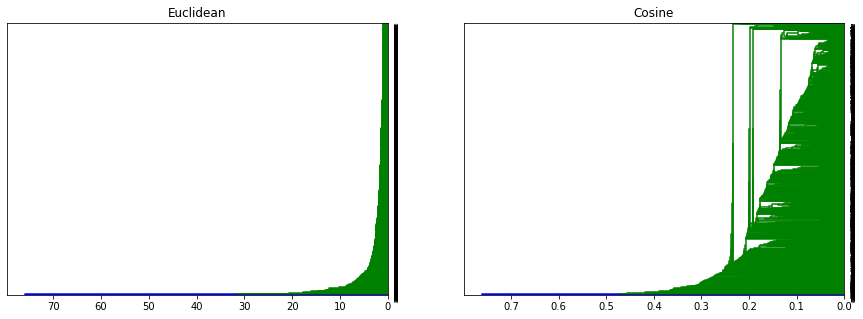

In [ ]:
# both plots
LINKS = [hclust_e, hclust_c]
TITLE = ['Euclidean', 'Cosine']

plt.figure(figsize=(15, 5))

# loop and build our plot
for i, m in enumerate(LINKS):
  plt.subplot(1, 2, i+1)
  plt.title(TITLE[i])
  dendrogram(m,
            #  labels = ps.index,
             leaf_rotation=90,
            #  leaf_font_size=10,
             orientation="left")
  
plt.show()

In [ ]:
#I would choose "cosine" over "euclidean".

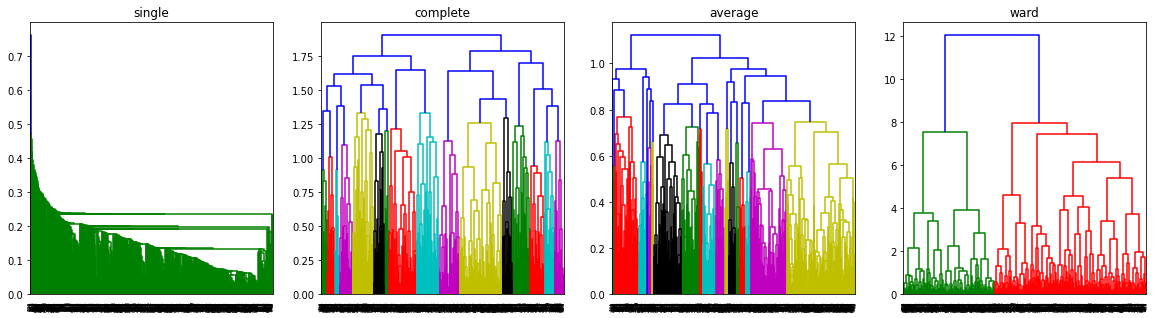

In [ ]:
METHODS = ['single', 'complete', 'average', 'ward']
plt.figure(figsize=(20,5))


# loop and build our plot
for i, m in enumerate(METHODS):
  plt.subplot(1, 4, i+1)
  plt.title(m)
  dendrogram(linkage(distc, method=m), 
             leaf_rotation=90)
  
plt.show()

In [ ]:
#"Categories" method divides categories in the most obvious way among the four.
# I would use "cosine" plus "categories" to compute further analysis.

In [ ]:
# the labels 
labs = fcluster(linkage(distc, method="complete"), 8, criterion="maxclust")

# confirm
np.unique(labs)

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

In [ ]:
stock_interpret['cluster']=labs

In [ ]:
stock_interpret.head(3)

,Quarter end,Shares,Shares split adjusted,Split factor,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Non-controlling interest,Preferred equity,Goodwill & intangibles,Long-term debt,Revenue,Earnings,Earnings available for common stockholders,EPS basic,EPS diluted,Dividend per share,Cash from operating activities,Cash from investing activities,Cash from financing activities,Cash change during period,Cash at end of period,Capital expenditures,Price,Price high,Price low,ROE,ROA,Book value of equity per share,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Equity to assets ratio,Net margin,Asset turnover,Free cash flow per share,Current ratio,ticker,quarter_end,cluster
0,0.0,3588919000,3588919000,1,118318000000,5.693800e+10,87263000000,2.031500e+10,30572000000,483000000,0,49881000000,51561000000,9.562000e+09,2333000000,2333000000,0.63,0.61,0.19,5.460000e+08,1.920000e+09,-1.002300e+10,-7631000000,10824000000,421000000,49.23,52.11,46.34,0.0982,0.0305,8.52,4.90,54.10,4.37,0.7371,1.6865,0.2584,0.1001,0.30,0.03,2.8028,ORCL,2018-11-30,7
1,0.0,261043625,261043625,1,53289000000,1.343800e+10,33995000000,9.496000e+09,19294000000,0,0,6908000000,16399000000,1.782400e+10,935000000,933000000,3.56,3.51,0.65,1.478000e+09,-1.480000e+09,-2.300000e+08,-246000000,2123000000,1455000000,233.57,259.25,207.90,0.2586,0.0950,73.91,3.21,13.20,12.17,0.1301,0.8500,0.3621,0.0722,1.31,0.09,1.4151,FDX,2018-11-30,8
2,0.0,359091176,359091176,1,7002400000,5.290000e+09,4577900000,4.306800e+09,2424500000,0,0,938600000,0,8.589000e+08,235800000,235800000,0.66,0.65,0.56,2.235000e+08,1.203000e+08,-2.733000e+08,70500000,510600000,36600000,69.45,76.02,62.89,0.4361,0.1366,6.75,10.44,26.51,21.27,0.8085,0.0000,0.3462,0.2799,0.49,0.52,1.2283,PAYX,2018-11-30,8


In [ ]:
#All data are evenly grouped into 8 clusters
stock_interpret.cluster.value_counts(dropna=False, sort=False)

1     99
2    111
3     87
4     71
5     62
6    164
7     56
8    105
Name: cluster, dtype: int64

In [ ]:
#Compute the mean of all data in each cluster
stock_numeric = stock_interpret.select_dtypes('number')

stock_profile = stock_numeric.groupby("cluster").mean()

stock_profile.T.head(3)

cluster,1,2,3,4,5,6,7,8
Quarter end,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Shares,4.217658e+08,7.673947e+08,2.665977e+08,219044212.0,2.410691e+08,1.871345e+08,2.028834e+09,4.369990e+08
Shares split adjusted,4.217658e+08,7.673947e+08,2.665977e+08,219044212.0,2.410691e+08,1.871345e+08,2.028834e+09,4.369990e+08


#### Discover the best cluster of stocks to buy

In [ ]:
stock_profile.head(3)

,Quarter end,Shares,Shares split adjusted,Split factor,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Non-controlling interest,Preferred equity,Goodwill & intangibles,Long-term debt,Revenue,Earnings,Earnings available for common stockholders,EPS basic,EPS diluted,Dividend per share,Cash from operating activities,Cash from investing activities,Cash from financing activities,Cash change during period,Cash at end of period,Capital expenditures,Price,Price high,Price low,ROE,ROA,Book value of equity per share,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Equity to assets ratio,Net margin,Asset turnover,Free cash flow per share,Current ratio
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,4.217658e+08,4.217658e+08,1.0,3.513921e+10,2.052355e+09,2.692892e+10,1.684710e+09,8.040971e+09,1.693203e+08,1.473745e+08,3.623899e+09,5.697344e+09,1.789881e+09,2.979966e+08,2.946548e+08,0.773333,0.763232,0.206217,4.504974e+08,-3.353963e+08,-1.474496e+08,-3.563834e+07,1.427864e+09,1.738067e+08,63.050808,68.455051,57.646869,0.142287,0.044904,23.739394,3.787273,77.978485,13.015253,0.491536,0.806488,0.347128,0.177444,0.363131,0.715859,0.569716
2,0.0,7.673947e+08,7.673947e+08,1.0,2.545634e+11,3.960680e+09,2.283843e+11,3.579535e+09,2.511483e+10,1.064229e+09,1.373142e+09,7.270338e+09,5.303715e+10,6.181309e+09,3.295565e+08,1.904766e+08,102.418649,102.403604,0.388333,2.013020e+09,-9.263275e+08,-6.709969e+08,3.913471e+08,1.566870e+10,4.643325e+08,2853.996486,3099.013694,2608.978559,0.038830,0.046223,2085.770991,9.577387,19.340270,23.438198,0.323398,2.975059,0.138764,0.111333,0.536036,38.819369,0.728608
3,0.0,2.665977e+08,2.665977e+08,1.0,1.942693e+10,2.215059e+09,1.553040e+10,1.789249e+09,3.752981e+09,1.435471e+08,4.856398e+07,2.320856e+09,4.379257e+09,1.608795e+09,1.183211e+07,4.567011e+06,-0.018276,-0.024713,0.151020,2.395156e+08,-1.483534e+08,-6.543355e+07,2.399063e+07,8.014511e+08,1.209397e+08,37.656782,41.665172,33.649080,-0.033755,-0.026024,18.239655,1.943103,8.822759,13.411034,0.197660,1.225509,0.238998,0.030670,0.558161,0.684598,1.168060


In [ ]:
S=['EPS basic', 'EPS diluted', 'Book value of equity per share', 'Free cash flow per share', 'Price']

N=['Shareholders equity', 'Earnings available for common stockholders', 'Earnings', 'Price']

strong_variables=stock_profile.loc[:, S]
normal_variables=stock_profile.loc[:, N]

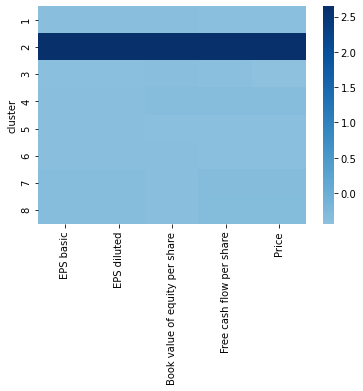

In [ ]:
# we can also plot this as a heatmap, but we should normalize the data
scp = StandardScaler()
strong_scaled = scp.fit_transform(strong_variables)

strong_scaled = pd.DataFrame(strong_scaled, 
                              index=strong_variables.index, 
                              columns=strong_variables.columns)

sns.heatmap(strong_scaled, cmap="Blues", center=0);
plt.savefig("strongly correlated data.jpg", dpi=200, bbox_inches="tight")

Four variables (EPS basic, EPS diluted, Book value of equity per share and Free cash flow per share) in all clusters strongly correlates with price. No unusual clusters detected.

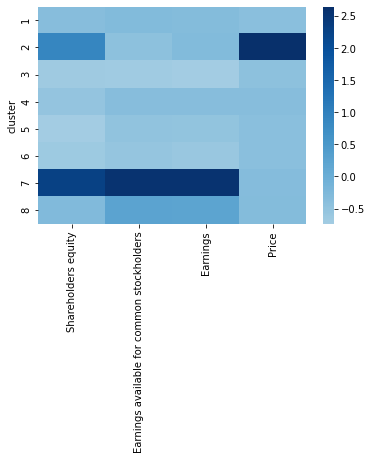

In [ ]:
# we can also plot this as a heatmap, but we should normalize the data
scp = StandardScaler()
normal_scaled = scp.fit_transform(normal_variables)

normal_scaled = pd.DataFrame(normal_scaled, 
                              index=normal_variables.index, 
                              columns=normal_variables.columns)

sns.heatmap(normal_scaled, cmap="Blues", center=0);
plt.savefig("normally correlated data.jpg", dpi=200, bbox_inches="tight")

Three variables (shareholders equity, earnings available for common stockholders, and earnings) are normally and positively correlated to price on average. In other words, high variables often pair with high stock price. Yet abnormal result appears on cluster 2 and 7. 
Low price but high variables on cluster 7 may represent undervalue, which is the sign of buy. High price but low variables on cluster 2 may reflect overvalue, which is the sign of sell. Thus, investing cluster 2 but divesting cluster 7 is the ideal way to leverage investment firm's portfolio.

#### Appendix: Collect tickers from all clusters

In [ ]:
stock_data['cluster']=labs

In [ ]:
stock_data.head()

,Quarter end,Shares,Shares split adjusted,Split factor,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Non-controlling interest,Preferred equity,Goodwill & intangibles,Long-term debt,Revenue,Earnings,Earnings available for common stockholders,EPS basic,EPS diluted,Dividend per share,Cash from operating activities,Cash from investing activities,Cash from financing activities,Cash change during period,Cash at end of period,Capital expenditures,Price,Price high,Price low,ROE,ROA,Book value of equity per share,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Equity to assets ratio,Net margin,Asset turnover,Free cash flow per share,Current ratio,ticker,quarter_end,cluster
0,NaN,3588919000,3588919000,1,118318000000,5.693800e+10,87263000000,2.031500e+10,30572000000,483000000,0,49881000000,51561000000,9.562000e+09,2333000000,2333000000,0.63,0.61,0.19,5.460000e+08,1.920000e+09,-1.002300e+10,-7631000000,10824000000,421000000,49.23,52.11,46.34,0.0982,0.0305,8.52,4.90,54.10,4.37,0.7371,1.6865,0.2584,0.1001,0.30,0.03,2.8028,ORCL,2018-11-30,7
1,NaN,261043625,261043625,1,53289000000,1.343800e+10,33995000000,9.496000e+09,19294000000,0,0,6908000000,16399000000,1.782400e+10,935000000,933000000,3.56,3.51,0.65,1.478000e+09,-1.480000e+09,-2.300000e+08,-246000000,2123000000,1455000000,233.57,259.25,207.90,0.2586,0.0950,73.91,3.21,13.20,12.17,0.1301,0.8500,0.3621,0.0722,1.31,0.09,1.4151,FDX,2018-11-30,8
2,NaN,359091176,359091176,1,7002400000,5.290000e+09,4577900000,4.306800e+09,2424500000,0,0,938600000,0,8.589000e+08,235800000,235800000,0.66,0.65,0.56,2.235000e+08,1.203000e+08,-2.733000e+08,70500000,510600000,36600000,69.45,76.02,62.89,0.4361,0.1366,6.75,10.44,26.51,21.27,0.8085,0.0000,0.3462,0.2799,0.49,0.52,1.2283,PAYX,2018-11-30,8
3,NaN,665541059,665541059,1,26706412000,1.354041e+10,13650844000,1.017634e+10,12678856000,376712000,0,6219615000,19896000,1.060555e+10,1274720000,1274720000,2.00,1.96,1.46,1.027508e+09,-2.728680e+08,-1.462168e+09,-697570000,4363790000,72892000,163.13,175.64,150.63,0.3961,0.1727,19.05,10.44,25.73,17.64,0.4436,0.0016,0.4747,0.0999,1.73,1.43,1.3306,ACN,2018-11-30,8
4,NaN,943444736,943444736,1,69941000000,2.008300e+10,43678000000,2.509900e+10,25609000000,654000000,0,28393000000,11646000000,3.379300e+10,1123000000,1123000000,1.18,1.18,0.44,4.590000e+08,-6.350000e+08,3.900000e+08,208000000,1183000000,470000000,76.37,85.31,67.42,0.1996,0.0763,27.14,2.79,15.09,5.74,0.3054,0.4548,0.3662,0.0396,1.93,-0.01,0.8002,WBA,2018-11-30,8


In [ ]:
cluster1=stock_data[stock_data['cluster']==1]
np.array(list(cluster1['ticker']))

array(['CRM', 'SNPS', 'CSCO', 'URI', 'GRA', 'ALK', 'DHI', 'MRO', 'ATVI',
       'ZION', 'QSII', 'KIM', 'Q', 'LUV', 'DNR', 'PMTC', 'DISH', 'ABK',
       'WY', 'REG', 'ARE', 'NTRS', 'NFLX', 'RRC', 'ETFC', 'FISV', 'CTXS',
       'PCG', 'VIA', 'MTB', 'O', 'CNX', 'PHM', 'MAA', 'MYL', 'STI', 'EQR',
       'SLM', 'IT', 'NFX', 'SLG', 'BEN', 'GPN', 'EXR', 'FHN', 'HBAN',
       'AFL', 'AMG', 'ACC', 'SBAC', 'TMK', 'PBCT', 'COG', 'IVZ', 'BSX',
       'WPX', 'VTR', 'CNP', 'PXD', 'CXO', 'NBL', 'UDR', 'PLD', 'CFG',
       'NYT', 'HAL', 'PCAR', 'PGR', 'BMY', 'GLAD', 'PNC', 'CMA', 'DFS',
       'NCLH', 'VRSK', 'FITB', 'HST', 'AAN', 'RF', 'KEY', 'SYMC', 'FTV',
       'INFO', 'RHT', 'KBH', 'LEN', 'CAG', 'GGP', 'LVLT', 'STR', 'PCL',
       'HCBK', 'FRX', 'NYX', 'BMC', 'XTO', 'EQ', 'BUD', 'SAF'],
      dtype='<U4')

In [ ]:
cluster2=stock_data[stock_data['cluster']==2]
np.array(list(cluster2['ticker']))

array(['AZO', 'LTD', 'HRB', 'NAV', 'DE', 'HD', 'NWL', 'JPM', 'DNB', 'CLX',
       'CHK', 'MS', 'ETR', 'AMT', 'BRK', 'MET', 'MGM', 'NAVI', 'FCX',
       'CF', 'FE', 'BXP', 'SBUX', 'FPL', 'EXC', 'CL', 'GS', 'DVA', 'BBT',
       'PEG', 'APC', 'AIG', 'HCA', 'THC', 'STT', 'UPS', 'MAS', 'DUK', 'D',
       'SYF', 'FRE', 'ORLY', 'ACE', 'WMB', 'KMB', 'SO', 'BAC', 'ALL',
       'SRE', 'BK', 'AXP', 'AVP', 'EXPE', 'PFG', 'VNO', 'MPC', 'USB',
       'AMP', 'COF', 'CI', 'RRD', 'SCHW', 'PPL', 'EK', 'TRV', 'WHR',
       'FNM', 'C', 'AES', 'UTX', 'WFC', 'PYPL', 'LNC', 'GNW', 'IDXX',
       'ED', 'UIS', 'MHP', 'GE', 'EIX', 'PBI', 'AMCX', 'MCO', 'HLT',
       'LTR', 'LMT', 'AEP', 'PRU', 'EQT', 'APA', 'HCN', 'DIS', 'MOT',
       'SYNT', 'XL', 'TSO', 'MJN', 'SE', 'CVC', 'TWC', 'WFR', 'DTV',
       'WAG', 'EP', 'RX', 'NCC', 'WB', 'MER', 'LEH', 'CFC', 'BSC'],
      dtype='<U4')

In [ ]:
cluster3=stock_data[stock_data['cluster']==3]
np.array(list(cluster3['ticker']))

array(['SHLD', 'JCP', 'SIG', 'GME', 'ADSK', 'CIEN', 'DISC', 'XYL', 'XRAY',
       'XEL', 'LUK', 'CNO', 'CR', 'PNW', 'AKRX', 'GLW', 'IPG', 'SEE',
       'HES', 'CZN', 'NWS', 'TDC', 'AA', 'AEE', 'NRG', 'CIT', 'MAT', 'NE',
       'AIZ', 'ENDP', 'MBI', 'WU', 'CMS', 'SWN', 'HIG', 'COTY', 'GT',
       'HOG', 'BHF', 'NI', 'EBAY', 'BLL', 'TSLA', 'UNM', 'DTE', 'OI',
       'FLS', 'SCG', 'AFG', 'RJF', 'NBR', 'DDR', 'WFT', 'AHL', 'JDSU',
       'HOLX', 'KMX', 'DYN', 'CPN', 'SPLS', 'STJ', 'LXK', 'ASH', 'TE',
       'ADT', 'GAS', 'POM', 'ANR', 'TEG', 'MWV', 'RSH', 'CMVT', 'PGN',
       'CEG', 'TIN', 'MI', 'AYE', 'PTV', 'BDK', 'PBG', 'JAVA', 'CTX',
       'ROH', 'SOV', 'AW', 'HPC', 'TT'], dtype='<U4')

In [ ]:
cluster4=stock_data[stock_data['cluster']==4]
np.array(list(cluster4['ticker']))

array(['KSS', 'SJM', 'CPB', 'NTAP', 'AJG', 'NLSN', 'AOC', 'IRM', 'DOV',
       'EQIX', 'APD', 'AVB', 'PX', 'MMC', 'HAS', 'CINF', 'GCI', 'SPG',
       'MUR', 'XRX', 'FRT', 'WLTW', 'ADS', 'APU', 'WYNN', 'WEC', 'HCP',
       'BLK', 'MCD', 'BDX', 'ROK', 'ADP', 'RE', 'CMI', 'AWK', 'WYN', 'R',
       'NU', 'FBHS', 'EMN', 'PNR', 'RCL', 'PSA', 'LNT', 'OKE', 'DLR',
       'MCHP', 'MDP', 'CCI', 'GPC', 'PH', 'MAC', 'PPG', 'ESS', 'SWK',
       'RL', 'HBI', 'WDC', 'HRS', 'MKC', 'DRI', 'DPS', 'DD', 'LLL', 'HOT',
       'ARG', 'CB', 'KRFT', 'OMX', 'HNZ', 'BNI'], dtype='<U4')

In [ ]:
cluster5=stock_data[stock_data['cluster']==5]
np.array(list(cluster5['ticker']))

array(['BIG', 'DLTR', 'FL', 'HIBB', 'TJX', 'ROST', 'ULTA', 'BBY', 'M',
       'JWN', 'AEO', 'GPS', 'DG', 'URBN', 'DCI', 'HRL', 'CHRW', 'ACM',
       'AN', 'CMG', 'CRVL', 'LEG', 'MED', 'JBHT', 'DLPH', 'EL', 'EXPD',
       'FLR', 'AOS', 'RHI', 'CBG', 'DF', 'HSIC', 'VFC', 'NUE', 'TSCO',
       'ARW', 'AMD', 'LSTR', 'SYY', 'AVY', 'SAM', 'TSN', 'KORS', 'SVU',
       'RAD', 'JBL', 'NKE', 'AYI', 'NUS', 'WFMI', 'NILE', 'FDO', 'BRLI',
       'PETM', 'SAPE', 'SWY', 'SLE', 'CBE', 'SUN', 'MHS', 'WWY'],
      dtype='<U4')

In [ ]:
cluster6=stock_data[stock_data['cluster']==6]
np.array(list(cluster6['ticker']))

array(['PVH', 'ANF', 'ADI', 'BKE', 'DDS', 'COO', 'RAVN', 'TIF', 'A',
       'PDCO', 'AAP', 'RIG', 'FSLR', 'ISRG', 'ACXM', 'ROP', 'LH', 'UA',
       'ETN', 'ALB', 'ATI', 'ITT', 'HP', 'TDG', 'MLM', 'BAX', 'UG', 'ECL',
       'COL', 'RMD', 'TAP', 'AKAM', 'VIVO', 'LM', 'LKQ', 'WIN', 'TSS',
       'X', 'RDC', 'TRIP', 'CA', 'NOV', 'AMSC', 'RSG', 'FLIR', 'AGCO',
       'WDR', 'IFF', 'NEM', 'UHS', 'APH', 'ESV', 'NDAQ', 'AMR', 'SRCL',
       'WPO', 'SYK', 'DO', 'SSP', 'TER', 'VMC', 'CBOE', 'BTU', 'BMS',
       'ACIW', 'PFIE', 'ARRS', 'PKI', 'DGX', 'AME', 'BWA', 'MTW', 'PETS',
       'EFX', 'ALXN', 'ANSS', 'INCY', 'IACI', 'FAST', 'TEX', 'PWR',
       'CTSH', 'MOS', 'OFLX', 'FIS', 'DV', 'TKR', 'ZMH', 'IR', 'JNPR',
       'SNA', 'XLNX', 'FOSL', 'QRVO', 'CERN', 'GRMN', 'CDNS', 'TXT',
       'PRGO', 'SANM', 'ODP', 'WAT', 'BC', 'MHK', 'COH', 'SAI', 'VAR',
       'JEC', 'SWKS', 'BBBY', 'CTAS', 'CVG', 'WRK', 'SNI', 'BCR', 'BHI',
       'LIZ', 'JNS', 'YHOO', 'LLTC', 'HAR', 'APOL', 'LNKD', 'ACAS', 'FTI',

In [ ]:
cluster7=stock_data[stock_data['cluster']==7]
np.array(list(cluster7['ticker']))

array(['ORCL', 'MU', 'HPE', 'HPQ', 'MDT', 'KMI', 'DVN', 'AMGN', 'CMCS',
       'VZ', 'ABT', 'PM', 'PG', 'CVX', 'CTL', 'SLB', 'ICE', 'MRK', 'EOG',
       'V', 'CME', 'HON', 'JNJ', 'FB', 'OXY', 'AMZN', 'LLY', 'GOOG', 'T',
       'JCI', 'S', 'COP', 'IBM', 'ABBV', 'XOM', 'KFT', 'MSFT', 'DOW',
       'MO', 'WPI', 'GILD', 'PFE', 'KHC', 'AAPL', 'TMO', 'INTC', 'KO',
       'DHR', 'PEP', 'CCL', 'TWX', 'RAI', 'EMC', 'DELL', 'SGP', 'WYE'],
      dtype='<U4')

In [ ]:
cluster8=stock_data[stock_data['cluster']==8]
np.array(list(cluster8['ticker']))

array(['FDX', 'PAYX', 'ACN', 'WBA', 'GIS', 'COST', 'KR', 'TGT', 'LOW',
       'WMT', 'BF', 'INTU', 'AMAT', 'NVDA', 'ESRX', 'RTN', 'TWTR', 'XEC',
       'AIV', 'CNC', 'VLO', 'CBS', 'MMM', 'CSC', 'REGN', 'YUM', 'CLF',
       'EW', 'WLP', 'ZTS', 'QCOM', 'UNP', 'MTD', 'MNST', 'GWW', 'ABC',
       'KSU', 'CHD', 'MA', 'DAL', 'GM', 'CSX', 'NOC', 'KLAC', 'ITW',
       'VRSN', 'CAT', 'BIIB', 'IP', 'PCLN', 'PSX', 'UNH', 'ERTS', 'CAH',
       'WEN', 'SHW', 'FMC', 'FFIV', 'LYB', 'MTG', 'NSC', 'CVS', 'F',
       'HUM', 'WM', 'VRTX', 'PKG', 'CELG', 'HSY', 'MCK', 'AET', 'GD',
       'OMC', 'EMR', 'ALEX', 'ADM', 'ALLE', 'DRE', 'TXN', 'FII', 'UAL',
       'TROW', 'ALGN', 'ILMN', 'BA', 'MAR', 'ABMD', 'K', 'WINA', 'MNK',
       'TEL', 'STX', 'LRCX', 'STZ', 'ADBE', 'FDS', 'MON', 'AVGO', 'CSRA',
       'CCE', 'AGN', 'COV', 'NOVL', 'UST', 'CCU'], dtype='<U4')